In [0]:
"""
This notebook is using the two following ressources: 

https://github.com/sahandha/eif
https://www.kaggle.com/mrlucasfischer/bert-the-spam-detector-that-uses-just-10-words 

We try to detect anomalies with Extended Isolation Forest on the SMS SPAM Collection Dataset

"""

'\nThis notebook is using the two following ressources: \n\nhttps://github.com/sahandha/eif\nhttps://www.kaggle.com/mrlucasfischer/bert-the-spam-detector-that-uses-just-10-words \n\nWe try to detect anomalies with Extended Isolation Forest on the SMS SPAM Collection Dataset\n\n'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
pip install eif

     |████████████████████████████████| 1.6MB 21.3MB/s 
  Created wheel for eif: filename=eif-2.0.2-cp36-cp36m-linux_x86_64.whl size=250765 sha256=237f1c345a0e435acf613b81035730c50213dcd9e2c00d7d698ac2aee08403e1
  Stored in directory: /root/.cache/pip/wheels/24/ff/c3/6a610ba4a6c8e968483ba15a0e38feacd7c0a26c932b2f91bd
Successfully built eif


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import random as rn
import eif as iso
import seaborn as sb
sb.set_style(style="whitegrid")
sb.set_color_codes()
import scipy.ndimage
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed
import pandas as pd

In [0]:
# Get data 40 tokens 
DATA_PATH = './drive/My Drive/data_nlp/data_SPAM/data'
df =  pd.read_csv(DATA_PATH + "/df_spam_XLM_en_2048_embed.csv")
X_train = np.load(file = DATA_PATH + "/40_tokens/train.npy", allow_pickle=True) 
X_train = np.array([x for x in X_train]).astype("float") # shape (2786, N_features_XLM)
Y_train = np.load(file = DATA_PATH + "/40_tokens/Y_train.npy", allow_pickle=True) # shape (2786, N_features_XLM)

X_test = np.load(file = DATA_PATH + "/40_tokens/test.npy", allow_pickle=True) 
X_test = np.array([x for x in X_test]).astype("float") # shape (2786, N_features_XLM)
Y_test = np.load(file = DATA_PATH + "/40_tokens/Y_test.npy", allow_pickle=True) # shape (2786, N_features_XLM)


import pickle 
with open(DATA_PATH + "/40_tokens/storage_indices_train_test.dic", "rb") as f: 
  storage_indices = pickle.load(f)

In [0]:
# Get data 20 tokens 
DATA_PATH = './drive/My Drive/data_nlp/data_SPAM/data'
df =  pd.read_csv(DATA_PATH + "/df_spam_XLM_en_2048_embed.csv")
X_train = np.load(file = DATA_PATH + "/20_tokens/train.npy", allow_pickle=True) 
X_train = np.array([x for x in X_train]).astype("float") # shape (2786, N_features_XLM)
Y_train = np.load(file = DATA_PATH + "/20_tokens/Y_train.npy", allow_pickle=True) # shape (2786, N_features_XLM)

import pickle 
with open(DATA_PATH + "/20_tokens/storage_indices_train_test.dic", "rb") as f: 
  storage_indices = pickle.load(f)

In [0]:
df_train["is_spam"].value_counts()

0    2427
1     359
Name: is_spam, dtype: int64

In [0]:
# Projection with t-SNE 

In [0]:
"""
Inspired by https://www.kaggle.com/mrlucasfischer/bert-the-spam-detector-that-uses-just-10-words 
"""
from sklearn.manifold import TSNE


X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_train)
X_embedded.shape

(2786, 2)

In [0]:
# Projection with UMAP 

In [0]:
! pip install umap-learn

In [0]:
import umap.umap_ as umap
reducer = umap.UMAP()
X_embedded = reducer.fit_transform(X_train)
X_embedded.shape

(2786, 2)

In [0]:
# df_train['train_embed_TSNE'] = [arr for arr in X_embedded]
df_train['train_embed_UMAP'] = [arr for arr in X_embedded]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
# df_train_interest = df_train.loc[:, ['train_embed_TSNE', 'is_spam']]
df_train_interest = df_train.loc[:, ['train_embed_UMAP', 'is_spam']]

In [0]:
df_train_interest.sample(5)

,train_embed_UMAP,is_spam
116,"[10.288548, 0.7212404]",1
3664,"[10.609101, -6.638192]",0
2796,"[-6.0170555, 1.9156815]",0
2055,"[-9.053893, 2.64404]",0
3229,"[-8.559787, 3.7839599]",0


In [0]:
pd.DataFrame(X_embedded)

,0,1
0,-0.019480,-41.883434
1,5.571419,37.147228
2,-8.381000,16.494364
3,-2.622587,43.590324
4,-3.146910,-33.773254
...,...,...
2781,-13.837067,-15.141514
2782,11.137671,23.021549
2783,21.486912,-45.764217
2784,-7.512868,-41.899231


In [0]:
# creating the dataframe for plotting
def creat_plotting_data(data, labels):
    """Creates a dataframe from the given data, used for plotting"""
    
    df = pd.DataFrame(data)
    df["is_spam"] = labels
    df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
    return df

# creating the dataframes for plotting
plotting_data_embedded = creat_plotting_data(X_embedded, labels = [y for y in Y_train])

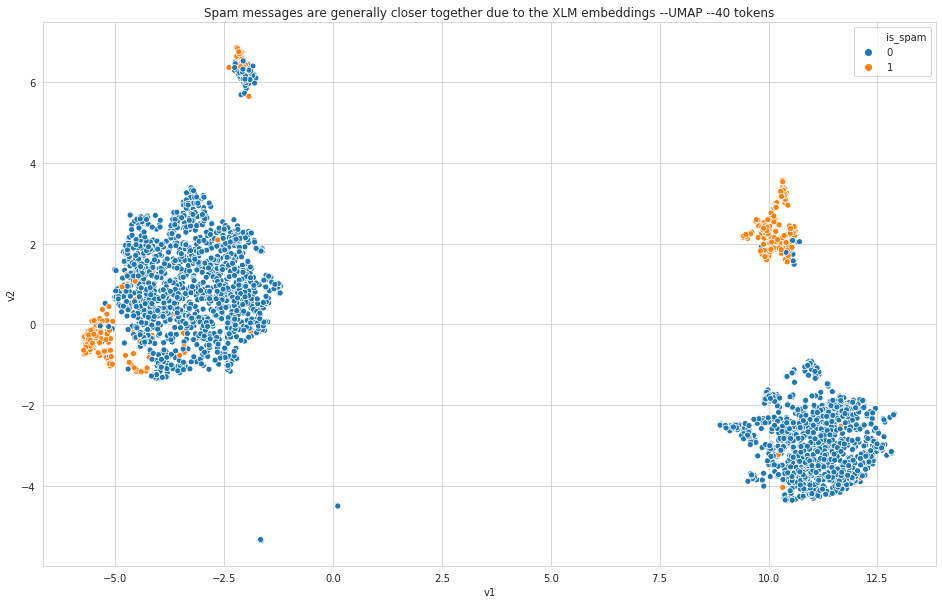

In [0]:
import seaborn as sns

plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", hue="is_spam", data=plotting_data_embedded)
ax.set(title = "Spam messages are generally closer together due to the XLM embeddings --UMAP --40 tokens")
plt.show()

In [0]:
# Build a very simple classifier based on UMAP project for 40 tokens with XLM MLM English


def simple_classifier(tuple_x_y):
  x_obs, y_obs = tuple_x_y
  x_1, y_1 = 10, 2
  x_2, y_2 = -4.5, 0
  if x_obs > x_1 and y_obs > y_1:
    y_label = 1
    return y_label 
  
  if x_obs < x_2 and y_obs < y_2: 
    y_label = 1 
    return y_label

  y_label = 0
  
  return y_label 

# Get labels for test set 
X_test_reduced = reducer.transform(X_test)

y_test_pred = [simple_classifier(tuple(obs)) for obs in X_test_reduced]

# Evaluate with report 
from sklearn.metrics import classification_report
target_names = ['nonSPAM', 'SPAM']

print(classification_report(Y_test, y_test_pred, target_names=target_names))
print("====================")

              precision    recall  f1-score   support

     nonSPAM       0.93      1.00      0.96      2398
        SPAM       0.96      0.51      0.66       388

    accuracy                           0.93      2786
   macro avg       0.94      0.75      0.81      2786
weighted avg       0.93      0.93      0.92      2786



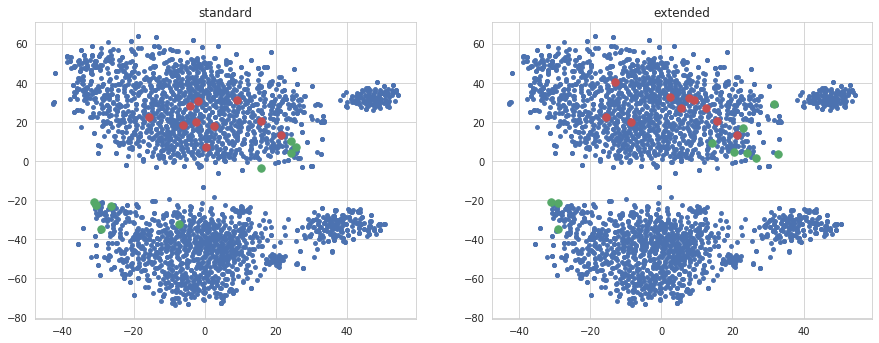

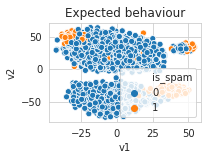

In [0]:
# Detecting automatically orange points with Extended Isolation Forest 

"""

Here we plot the points and we highlight 10 points with highest and 10 points with lowest anomaly scores. The two plots provide a comparison between the two algorithms.

Anomalies in Green
Lowest Anomaly Scores in Red 
"""
ss0=np.argsort(S0)
ss1=np.argsort(S1)

x = X_embedded[:, 0]
y = X_embedded[:, 1]

f = plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss0[-10:]],y[ss0[-10:]],s=55,c='g') # highest anomaly scores 
plt.scatter(x[ss0[:10]],y[ss0[:10]],s=55,c='r') # lowest anomaly scores
# ax = sns.scatterplot(x="v1", y="v2", hue="is_spam", data=plotting_data_embedded)
plt.title('standard')

plt.subplot(2,2,2)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss1[-10:]],y[ss1[-10:]],s=55,c='g')
plt.scatter(x[ss1[:10]],y[ss1[:10]],s=55,c='r')
plt.title('extended')
plt.show()

plt.subplot(2,2, 4)
ax = sns.scatterplot(x="v1", y="v2", hue="is_spam", data=plotting_data_embedded)
ax.set(title = "Expected behaviour")
plt.show()

In [0]:
# CLEANED CODE: 

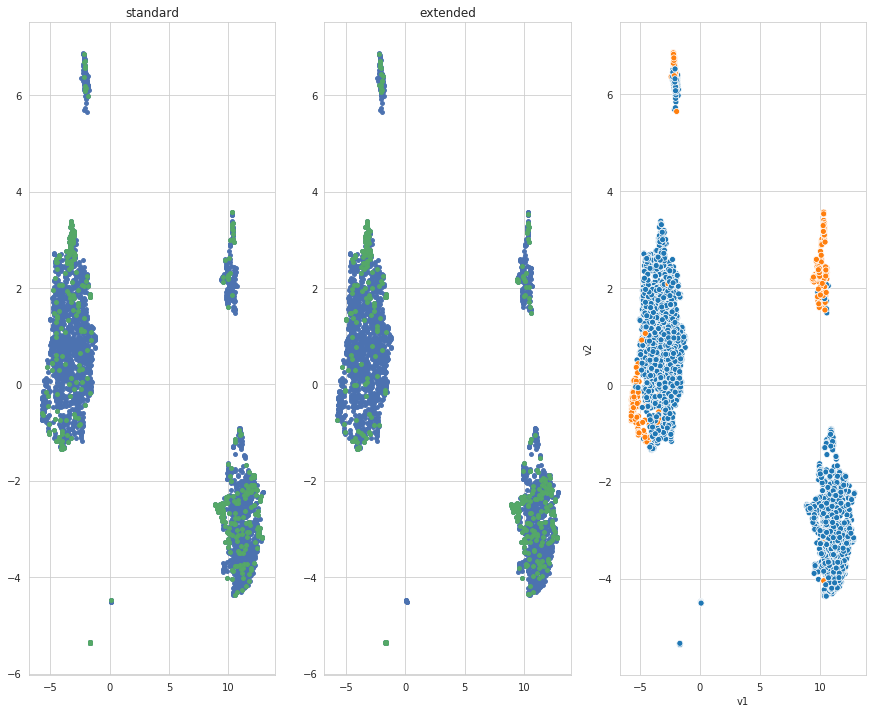

In [0]:
# Increasing Sample Size 
SAMPLE_SIZE = 512

F0  = iso.iForest(X_train, ntrees=200, sample_size=SAMPLE_SIZE, ExtensionLevel=0) # ExtensionLevel=0 is the same as regular Isolation Forest
F1 = iso.iForest(X_train, ntrees=200, sample_size=SAMPLE_SIZE, ExtensionLevel=1) 
S1 = F1.compute_paths(X_in=X_train) 
S0 = F0.compute_paths(X_in=X_train)


##### Getting indices of the observations from the lower anomaly scores to the highest anomaly scores ###### 
ss0=np.argsort(S0)
ss1 = np.argsort(S1)

##### Defining x axis and y axis components ####### 
x = X_embedded[:, 0]
y = X_embedded[:, 1]

###### Plotting ####### 
f = plt.figure(figsize=(15,12))
plt.subplot(1,3,1)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss0[-400:]],y[ss0[-400:]],s=15,c='g') # highest anomaly scores 
# plt.scatter(x[ss0[:100]],y[ss0[:100]],s=55,c='r') # lowest anomaly scores
# ax = sns.scatterplot(x="v1", y="v2", hue="is_spam", data=plotting_data_embedded)
plt.title('standard')

plt.subplot(1,3,2)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss1[-400:]],y[ss1[-400:]],s=15,c='g')
# plt.scatter(x[ss1[:100]],y[ss1[:100]],s=55,c='r')
plt.title('extended')


plt.subplot(1,3, 3)
s = sns.scatterplot(x="v1", y="v2", hue="is_spam", data=plotting_data_embedded)
s.legend_.remove()
ax.set(title = "Expected behaviour")
plt.show()

In [0]:
from sklearn.metrics import classification_report
target_names = ['nonSPAM', 'SPAM']


S1_test = F1.compute_paths(X_in=X_test) 
S0_test = F0.compute_paths(X_in=X_test)


##### Getting indices of the observations from the lower anomaly scores to the highest anomaly scores ###### 
ss0_test = np.argsort(S0_test)
ss1_test = np.argsort(S1_test)

print("---------For Extended Isolation Forest -----------")
for expected_nb_anomalies in [300,400]: 
  # print("PRECISION/RECALL")
  # print(get_precision(y_true = Y_test, indices_anomalies = ss1_test[-expected_nb_anomalies:]))
  # print(get_recall(y_true = Y_test, indices_anomalies = ss1_test[-expected_nb_anomalies:]))
  N = Y_test.shape[0] # nb_observations 
  # print(indices_anomalies)
  indices_anomalies = ss1_test[-expected_nb_anomalies:]
  y_pred = np.array([0 if i not in indices_anomalies else 1 for i in range(N)]) 
  print(classification_report(Y_test, y_pred, target_names=target_names))
  print("====================")


print("---------For Standard Isolation Forest -----------")
for expected_nb_anomalies in [300,400]: 
  # print("PRECISION/RECALL")
  # print(get_precision(y_true = Y_test, indices_anomalies = ss0_test[-expected_nb_anomalies:]))
  # print(get_recall(y_true = Y_test, indices_anomalies = ss0_test[-expected_nb_anomalies:]))

  N = Y_test.shape[0] # nb_observations 
  # print(indices_anomalies)
  indices_anomalies = ss0_test[-expected_nb_anomalies:]
  y_pred = np.array([0 if i not in indices_anomalies else 1 for i in range(N)]) 
  print(classification_report(Y_test, y_pred, target_names=target_names))
  print("====================")

---------For Extended Isolation Forest -----------
              precision    recall  f1-score   support

     nonSPAM       0.85      0.88      0.87      2398
        SPAM       0.06      0.05      0.05       388

    accuracy                           0.77      2786
   macro avg       0.46      0.46      0.46      2786
weighted avg       0.74      0.77      0.75      2786

              precision    recall  f1-score   support

     nonSPAM       0.85      0.85      0.85      2398
        SPAM       0.10      0.11      0.10       388

    accuracy                           0.75      2786
   macro avg       0.48      0.48      0.48      2786
weighted avg       0.75      0.75      0.75      2786

---------For Standard Isolation Forest -----------
              precision    recall  f1-score   support

     nonSPAM       0.86      0.89      0.87      2398
        SPAM       0.10      0.08      0.09       388

    accuracy                           0.78      2786
   macro avg       0.48   

In [0]:
# Cleaned Code: Fit UMAP data with iForest and EIF 

In [0]:
###### Fitting EIF on Projected data with PCA #########

# First we get the data 
# Get data 
DATA_PATH = './drive/My Drive/data_nlp/data_SPAM/data'
df =  pd.read_csv(DATA_PATH + "/df_spam_XLM_en_2048_embed.csv")
X_train = np.load(file = DATA_PATH + "/40_tokens/train.npy", allow_pickle=True) 
X_train = np.array([x for x in X_train]).astype("float") # shape (2786, N_features_XLM)
Y_train = np.load(file = DATA_PATH + "/40_tokens/Y_train.npy", allow_pickle=True) # shape (2786, N_features_XLM)

import pickle 
with open(DATA_PATH + "/40_tokens/storage_indices_train_test.dic", "rb") as f: 
  storage_indices = pickle.load(f)

df_train, df_test = df.iloc[storage_indices["train"],:], df.iloc[storage_indices["test"],:]

# Project the data with UMAP 
import umap.umap_ as umap
reducer = umap.UMAP(n_neighbors=15,n_components=5)
X_train_embedded = reducer.fit_transform(X_train).astype("float")
print(X_train_embedded.shape)


method_projection = "UMAP"
df_train['train_embed_{}'.format(method_projection)] = [arr for arr in X_embedded]
df_train_interest = df_train.loc[:, ['train_embed_{}'.format(method_projection), 'is_spam']]

# Fit the projected data with our Isolation Forest model, Extended Isolation Forest model 

F0  = iso.iForest(X_train_embedded, ntrees=200, sample_size=256, ExtensionLevel=0) # ExtensionLevel=0 is the same as regular Isolation Forest
F1  = iso.iForest(X_train_embedded, ntrees=200, sample_size=256, ExtensionLevel=1)

S0 = F0.compute_paths(X_in=X_train_embedded)
S1 = F1.compute_paths(X_in=X_train_embedded) 

ss0=np.argsort(S0)
ss1=np.argsort(S1)

# # Plotting data 
# # creating the dataframe for plotting
# def creat_plotting_data(data, labels):
#     """Creates a dataframe from the given data, used for plotting"""
    
#     df = pd.DataFrame(data)
#     df["is_spam"] = labels
#     df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
#     return df

# # creating the dataframes for plotting
# plotting_data_embedded = creat_plotting_data(X_train_embedded, labels = [y for y in Y_train])

# import seaborn as sns

# plt.figure(figsize=(16, 10))
# ax = sns.scatterplot(x="v1", y="v2", hue="is_spam", data=plotting_data_embedded)
# ax.set(title = "Spam messages are generally closer together due to the XLM embeddings")
# plt.show()


######### Detecting the anomalies on the test set ##########

# First, project test set on the same space as training data with UMAP
print("Projecting X_test on 2d space with UMAP")
X_test_reduced = reducer.transform(X_test).astype("float")

# Then predict anomalies based on fitted iForest and EIF on training data 
S0_test = F0.compute_paths(X_in=X_test_reduced)
S1_test = F1.compute_paths(X_in=X_test_reduced) 

##### Getting indices of the observations from the lower anomaly scores to the highest anomaly scores ###### 
ss0_test = np.argsort(S0_test)
ss1_test = np.argsort(S1_test)

print("---------For Extended Isolation Forest -----------")
for expected_nb_anomalies in [300,400]: 
  # print("PRECISION/RECALL")
  # print(get_precision(y_true = Y_test, indices_anomalies = ss1_test[-expected_nb_anomalies:]))
  # print(get_recall(y_true = Y_test, indices_anomalies = ss1_test[-expected_nb_anomalies:]))
  N = Y_test.shape[0] # nb_observations 
  # print(indices_anomalies)
  indices_anomalies = ss1_test[-expected_nb_anomalies:]
  y_pred = np.array([0 if i not in indices_anomalies else 1 for i in range(N)]) 
  print(classification_report(Y_test, y_pred, target_names=target_names))
  print("====================")


print("---------For Standard Isolation Forest -----------")
for expected_nb_anomalies in [300,400]: 
  # print("PRECISION/RECALL")
  # print(get_precision(y_true = Y_test, indices_anomalies = ss0_test[-expected_nb_anomalies:]))
  # print(get_recall(y_true = Y_test, indices_anomalies = ss0_test[-expected_nb_anomalies:]))

  N = Y_test.shape[0] # nb_observations 
  # print(indices_anomalies)
  indices_anomalies = ss0_test[-expected_nb_anomalies:]
  y_pred = np.array([0 if i not in indices_anomalies else 1 for i in range(N)]) 
  print(classification_report(Y_test, y_pred, target_names=target_names))
  print("====================")

(2786, 5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Projecting X_test on 2d space with UMAP
---------For Extended Isolation Forest -----------
              precision    recall  f1-score   support

     nonSPAM       0.85      0.88      0.86      2398
        SPAM       0.01      0.01      0.01       388

    accuracy                           0.76      2786
   macro avg       0.43      0.44      0.43      2786
weighted avg       0.73      0.76      0.74      2786

              precision    recall  f1-score   support

     nonSPAM       0.84      0.83      0.84      2398
        SPAM       0.01      0.01      0.01       388

    accuracy                           0.72      2786
   macro avg       0.42      0.42      0.42      2786
weighted avg       0.72      0.72      0.72      2786

---------For Standard Isolation Forest -----------
              precision    recall  f1-score   support

     nonSPAM       0.84      0.88      0.86      2398
        SPAM       0.00      0.00      0.00       388

    accuracy                           0

Text(0.5, 1.0, 'standard')

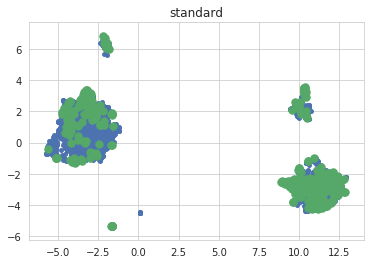

In [0]:
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss0[-400:]],y[ss0[-400:]],s=55,c='g') # highest anomaly scores 
# plt.scatter(x[ss0[:100]],y[ss0[:100]],s=55,c='r') # lowest anomaly scores
# ax = sns.scatterplot(x="v1", y="v2", hue="is_spam", data=plotting_data_embedded)
plt.title('standard')

In [0]:
EXPECTED_NB_ANOMALIES = df_train["is_spam"].value_counts()[1] # Actual nb of spams 
INDICES_ANOMALIES_ARR = ss1[-EXPECTED_NB_ANOMALIES:]

# cool implementation of precision/recall in pytorch:
# https://github.com/pytorch/ignite/issues/310
def get_precision(y_true, indices_anomalies = INDICES_ANOMALIES_ARR, expected_nb_anomalies = EXPECTED_NB_ANOMALIES):
  """
  ss1 is the array of indices of the observations from the lowest to the highest 

  precision = p(y_true = 1 | y_pred = 1) = p(y_true =1, y_pred = 1) / p(y_pred = 1)
  """
  N = y_true.shape[0] # nb_observations 
  # print(indices_anomalies)
  y_pred = np.array([0 if i not in indices_anomalies else 1 for i in range(N)]) # set to 1 all anomalies, 0 otherwise given our predictions from EIF
  precision = np.mean(y_pred * y_true)/np.mean(y_pred)
  return precision 

def get_recall(y_true, indices_anomalies = INDICES_ANOMALIES_ARR, expected_nb_anomalies = EXPECTED_NB_ANOMALIES):
  """
  ss1 is the array of indices of the observations from the lowest to the highest 

  recall = p(y_pred = 1 | y_true = 1) = p(y_true =1, y_pred = 1) / p(y_true = 1)
  """
  N = y_true.shape[0] # nb_observations 
  # print(indices_anomalies)
  y_pred = np.array([0 if i not in indices_anomalies else 1 for i in range(N)]) # set to 1 all anomalies, 0 otherwise given our predictions from EIF
  recall = np.mean(y_pred * y_true)/np.mean(y_true)
  return recall 

for expected_nb_anomalies in [100,200,300,400,500, 600]: 
  print("PRECISION/RECALL")
  print(get_precision(y_true = Y_train, indices_anomalies = ss1[-expected_nb_anomalies:]))
  print(get_recall(y_true = Y_train, indices_anomalies = ss1[-expected_nb_anomalies:]))
  print("====================")

PRECISION/RECALL
0.01
0.002785515320334262
PRECISION/RECALL
0.06
0.03342618384401114
PRECISION/RECALL
0.10333333333333333
0.08635097493036212
PRECISION/RECALL
0.1175
0.1309192200557103
PRECISION/RECALL
0.128
0.17827298050139276
PRECISION/RECALL
0.13499999999999998
0.2256267409470752


(2786, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


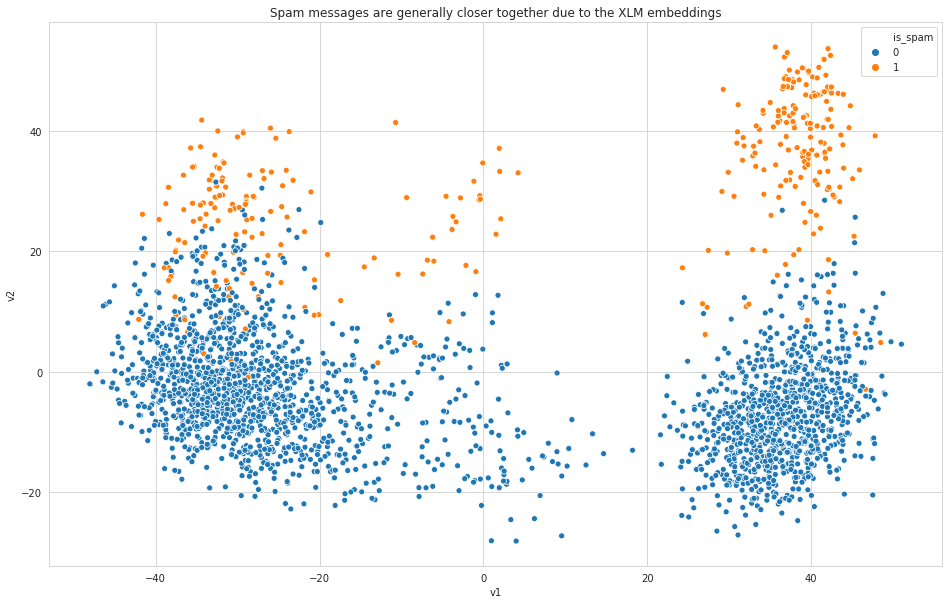

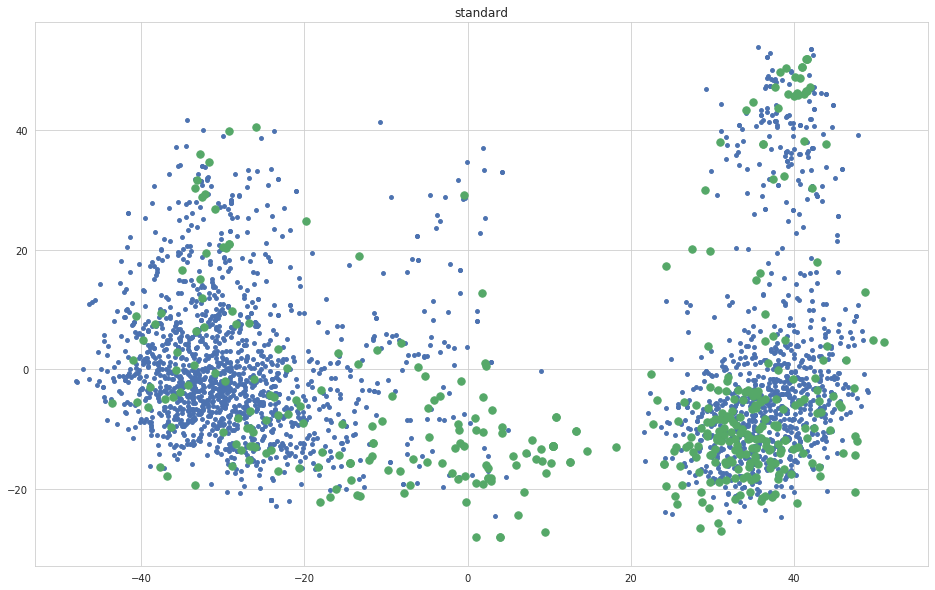

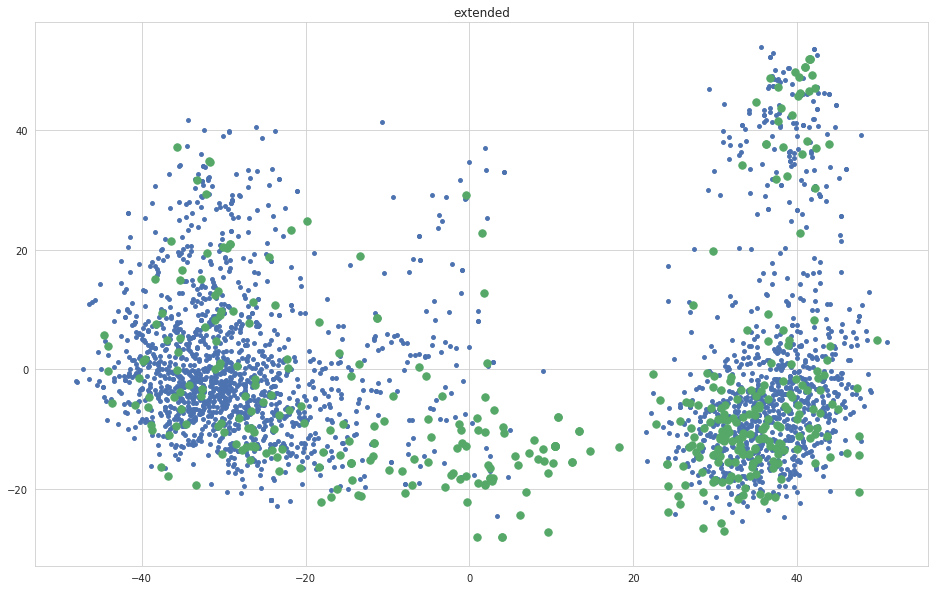

In [0]:
###### Fitting EIF on Projected data with PCA #########

# First we get the data 
# Get data 
DATA_PATH = './drive/My Drive/data_nlp/data_SPAM/data'
df =  pd.read_csv(DATA_PATH + "/df_spam_XLM_en_2048_embed.csv")
X_train = np.load(file = DATA_PATH + "/40_tokens/train.npy", allow_pickle=True) 
X_train = np.array([x for x in X_train]).astype("float") # shape (2786, N_features_XLM)
Y_train = np.load(file = DATA_PATH + "/40_tokens/Y_train.npy", allow_pickle=True) # shape (2786, N_features_XLM)

import pickle 
with open(DATA_PATH + "/40_tokens/storage_indices_train_test.dic", "rb") as f: 
  storage_indices = pickle.load(f)

df_train, df_test = df.iloc[storage_indices["train"],:], df.iloc[storage_indices["test"],:]

# Project the data with PCA 

"""
Inspired by https://www.kaggle.com/mrlucasfischer/bert-the-spam-detector-that-uses-just-10-words 
"""
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2, random_state = 42)
pca.fit(X)



# X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_train)
X_embedded = pca.fit_transform(X_train)
print(X_embedded.shape)

method_projection = "PCA"
df_train['train_embed_{}'.format(method_projection)] = [arr for arr in X_embedded]
df_train_interest = df_train.loc[:, ['train_embed_{}'.format(method_projection), 'is_spam']]

# Fit the data with our Isolation Forest model, Extended Isolation Forest model 

F0  = iso.iForest(X_train, ntrees=200, sample_size=256, ExtensionLevel=0) # ExtensionLevel=0 is the same as regular Isolation Forest
F1  = iso.iForest(X_train, ntrees=200, sample_size=256, ExtensionLevel=1)

S0 = F0.compute_paths(X_in=X_train)
S1 = F1.compute_paths(X_in=X_train) 

ss0=np.argsort(S0)
ss1=np.argsort(S1)

# Plotting data 
# creating the dataframe for plotting
def creat_plotting_data(data, labels):
    """Creates a dataframe from the given data, used for plotting"""
    
    df = pd.DataFrame(data)
    df["is_spam"] = labels
    df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
    return df

# creating the dataframes for plotting
plotting_data_embedded = creat_plotting_data(X_embedded, labels = [y for y in Y_train])

import seaborn as sns

plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", hue="is_spam", data=plotting_data_embedded)
ax.set(title = "Spam messages are generally closer together due to the XLM embeddings")
plt.show()


# Detecting the anomalies and plotting them 
# Increasing Sample Size 
SAMPLE_SIZE = 512
F1 = iso.iForest(X_train, ntrees=200, sample_size=SAMPLE_SIZE, ExtensionLevel=1) 
S1 = F1.compute_paths(X_in=X_train) 

##### Getting indices of the observations from the lower anomaly scores to the highest anomaly scores ###### 
ss1 = np.argsort(S1)

##### Defining x axis and y axis components ####### 
x = X_embedded[:, 0]
y = X_embedded[:, 1]

###### Plotting ####### 
f = plt.figure(figsize=(16, 10))
# plt.subplot(1,3,1)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss0[-400:]],y[ss0[-400:]],s=55,c='g') # highest anomaly scores 
# plt.scatter(x[ss0[:100]],y[ss0[:100]],s=55,c='r') # lowest anomaly scores
# ax = sns.scatterplot(x="v1", y="v2", hue="is_spam", data=plotting_data_embedded)
plt.title('standard')
plt.show()

# plt.subplot(1,3,2)
plt.figure(figsize = (16, 10))
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss1[-400:]],y[ss1[-400:]],s=55,c='g')
# plt.scatter(x[ss1[:100]],y[ss1[:100]],s=55,c='r')
plt.title('extended')
plt.show()

# plt.subplot(1,3, 3)
# sns.scatterplot(x="v1", y="v2", hue="is_spam", data=plotting_data_embedded)
# ax.set(title = "Expected behaviour")
# plt.show()

In [0]:
from sklearn.metrics import classification_report
target_names = ['nonSPAM', 'SPAM']


for expected_nb_anomalies in [100,200,300,400,500, 600]: 
  print("PRECISION/RECALL")
  print(get_precision(y_true = Y_train, indices_anomalies = ss1[-expected_nb_anomalies:]))
  print(get_recall(y_true = Y_train, indices_anomalies = ss1[-expected_nb_anomalies:]))

  N = Y_train.shape[0] # nb_observations 
  # print(indices_anomalies)
  indices_anomalies = ss1[-expected_nb_anomalies:]
  y_pred = np.array([0 if i not in indices_anomalies else 1 for i in range(N)]) 
  print(classification_report(Y_train, y_pred, target_names=target_names))
  print("====================")

PRECISION/RECALL
0.01
0.002785515320334262
              precision    recall  f1-score   support

     nonSPAM       0.87      0.96      0.91      2427
        SPAM       0.01      0.00      0.00       359

    accuracy                           0.84      2786
   macro avg       0.44      0.48      0.46      2786
weighted avg       0.76      0.84      0.79      2786

PRECISION/RECALL
0.06
0.03342618384401114
              precision    recall  f1-score   support

     nonSPAM       0.87      0.92      0.89      2427
        SPAM       0.06      0.03      0.04       359

    accuracy                           0.81      2786
   macro avg       0.46      0.48      0.47      2786
weighted avg       0.76      0.81      0.78      2786

PRECISION/RECALL
0.10333333333333333
0.08635097493036212
              precision    recall  f1-score   support

     nonSPAM       0.87      0.89      0.88      2427
        SPAM       0.10      0.09      0.09       359

    accuracy                           0